In [1]:
# from keras.layers import Input, Dense, Conv2D, Reshape, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout
from tensorflow import Tensor
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard
# from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
# from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

class FeatureExtractor:
    def __init__(self):
        self.encoder_model = None
        self.model = None
        return
    
    def relu_bn(self, inputs: Tensor) -> Tensor:
        relu = ReLU()(inputs)
        bn = BatchNormalization()(relu)
        return bn

    def residual_block(self, x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
        y = Conv2D(kernel_size=kernel_size,
                   strides= (1 if not downsample else 2),
                   filters=filters,
                   padding="same")(x)
        y = self.relu_bn(y)
        y = Conv2D(kernel_size=kernel_size,
                   strides=1,
                   filters=filters,
                   padding="same")(y)

        if downsample:
            x = Conv2D(kernel_size=1,
                       strides=2,
                       filters=filters,
                       padding="same")(x)
        out = Add()([x, y])
        out = self.relu_bn(out)
        return out
    
    def build(self, input_dims):
        inputs = Input(shape=input_dims)
        num_filters = 64

        t = BatchNormalization()(inputs)
        t = Conv2D(kernel_size=3,
                   strides=1,
                   filters=num_filters,
                   padding="same")(t)
        t = self.relu_bn(t)

        num_blocks_list = [2, 5, 5, 2]
        for i in range(len(num_blocks_list)):
            num_blocks = num_blocks_list[i]
            for j in range(num_blocks):
                t = self.residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
            num_filters *= 2

        t = AveragePooling2D(4)(t)
        t = Flatten()(t)
        outputs = Dense(10, activation='softmax')(t)

        self.model = Model(inputs, outputs)
        self.feature_extractor = Model(inputs, t)

        self.model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return
    
    def load(self, model_file, encoder_model_file):
        self.encoder_model = load_model(encoder_model_file)
        self.model = load_model(model_file)
        return
    
    def train(self, train_input, train_output, val_input, val_output):
        history = self.model.fit(x=train_input, y=train_output,
                      epochs=20, 
                      batch_size=128,
                      verbose=1,
                      validation_data=(val_input, val_output))
        return history
    
    def encoder_predict(self, test_input):
        return self.encoder_model.predict(test_input)
    
    def predict(self, test_input):
        return self.model.predict(test_input)
    
    def save(self, model_file, encoder_model_file):
        self.model.save(model_file)
        self.encoder_model.save(encoder_model_file)
        return

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.layers import GaussianNoise
import numpy as np
from sklearn import preprocessing

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

GN = GaussianNoise(0.08)

x_train = x_train.astype(np.float32)
x_train = GN(x_train,training=True)

y_train = y_train.astype(np.float32)
y_train = GN(y_train,training=True)

x_test = x_test.astype(np.float32)
x_test = GN(x_test,training=True)

y_test = y_test.astype(np.float32)
y_test = GN(y_test,training=True)

print (x_train.shape)
print (x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
fe = FeatureExtractor()
fe.build((32, 32, 3))

In [4]:
history = fe.train(x_train, y_train, x_test, y_test)

Epoch 1/20
391/391 [==============================] - 3880s 10s/step - loss: 2.0624 - accuracy: 0.0000e+00 - val_loss: 2.2042 - val_accuracy: 0.0000e+00
Epoch 2/20
391/391 [==============================] - 3680s 9s/step - loss: 1.6324 - accuracy: 0.0000e+00 - val_loss: 5.0478 - val_accuracy: 0.0000e+00
Epoch 3/20
391/391 [==============================] - 3680s 9s/step - loss: 1.4578 - accuracy: 0.0000e+00 - val_loss: 1.6634 - val_accuracy: 0.0000e+00
Epoch 4/20
391/391 [==============================] - 3670s 9s/step - loss: 1.3348 - accuracy: 0.0000e+00 - val_loss: 1.6605 - val_accuracy: 0.0000e+00
Epoch 5/20
391/391 [==============================] - 3674s 9s/step - loss: 1.2302 - accuracy: 0.0000e+00 - val_loss: 1.4231 - val_accuracy: 0.0000e+00
Epoch 6/20
391/391 [==============================] - 3668s 9s/step - loss: 1.1476 - accuracy: 0.0000e+00 - val_loss: 1.2301 - val_accuracy: 0.0000e+00
Epoch 7/20
391/391 [==============================] - 3675s 9s/step - loss: 1.0712 - ac

KeyboardInterrupt: 

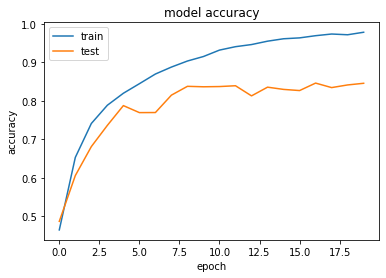

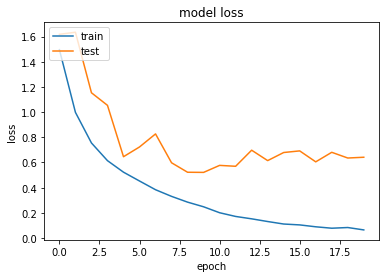

In [5]:
import matplotlib.pyplot as plt
print(history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
fe.save('denoising-features.h5', 'denoising-features-model.h5')
print ("Model saved!")

AttributeError: 'NoneType' object has no attribute 'save'